In [1]:
#matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from dataset.dataloader import *
import operators as ops
import torch
import os

CKPT_DIR = "./logs/checkpoints"
LOAD_PRETRAINED = True

In [2]:
import torch.nn as nn
import torch

class torch_VGG8(nn.Module):
    def __init__(self):
        super(torch_VGG8, self,).__init__()
        # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
        self.Layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 2 (B, 32, 28, 28) -> (B, 64, 14, 14)
        self.Layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
        self.Layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
        self.Layer4 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
        self.Layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
        self.Layer6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.Layer7 = nn.Sequential(
            nn.Linear(in_features=256*7*7, out_features=256, bias=True,),
            nn.ReLU(True)
        )
        # Layer 8 (B, 256) -> (B, 10)
        self.Layer8 = nn.Sequential(
            nn.Linear(in_features=256, out_features=10, bias=True,),
        )

    def forward(self, x):
        # L1~L6: Conv + ReLU + (MaxPool)
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)
        x = self.Layer5(x)
        x = self.Layer6(x)
        # L7: FC + ReLU
        x = x.view(x.size(0), -1)
        x = self.Layer7(x)
        # L8: FC
        x = self.Layer8(x)
        return x


In [3]:
class VGG8:
    def __init__(self):
        self.criterion = ops.SoftmaxWithLoss()
        self.conv_layers = [
            # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
            ops.Conv2D(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1, name="L1_C"),
            ops.ReLU(name="L1_R"),

            # Layer2 (B, 32, 28, 28) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, name="L2_C"),
            ops.ReLU(name="L2_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L2_M"),
            
            # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1, name="L3_C"),
            ops.ReLU(name="L3_R"),

            # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
            ops.Conv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, name="L4_C"),
            ops.ReLU(name="L4_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L4_M"),

            # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, name="L5_C"),
            ops.ReLU(name="L5_R"),

            # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, name="L6_C"),
            ops.ReLU(name="L6_R")
        ]

        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.fc_layers = [
            ops.FullyConnected(in_feature=256*7*7, out_feature=256, name="L7_FC"),
            ops.ReLU(name="L7_R"),

        # Layer 8 (B, 256) -> (B, 10)
            ops.FullyConnected(in_feature=256, out_feature=10, name="L8_FC")
        ]

    def backprop(self, lr, m=None) -> None:
        # Backward
        #dout = self.criterion.backward(pred, label)
        dout = self.criterion.backward()
        for i in range(len(self.fc_layers)-1, -1, -1):
            dout = self.fc_layers[i].backward(dout)
        dout = dout.reshape(dout.shape[0], 256, 7, 7)
        for i in range(len(self.conv_layers)-1, -1, -1):
            dout = self.conv_layers[i].backward(dout)
        # Update
        for layer in self.conv_layers:
            layer.update(lr, m)
        for layer in self.fc_layers:
            layer.update(lr, m)
        return dout

    def forward(self, x: np.ndarray):
        i = 0
        for layer in self.conv_layers:
            i+=1
            x = layer.forward(x) 
        x = x.reshape(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer.forward(x)
        return x

    def save(self, fileName: str):
        with open(fileName, "wb") as f:
            pickle.dump(self, f)

    def load(self, fileName: str):
        with open(fileName, "rb") as f:
            self = pickle.load(f)

In [4]:
model = VGG8()

In [5]:
if LOAD_PRETRAINED:
    # Load pretrained weights from torch
    torch_vgg8 = torch_VGG8()
    torch_vgg8.load_state_dict(torch.load("torch_vgg8.pt", map_location=torch.device('cpu')))

    for i, p in enumerate(torch_vgg8.Layer1.parameters()):
        if (i == 0):
            print(f"Load L1 Weight:({p.shape},{model.conv_layers[0].W.shape})")
            model.conv_layers[0].W = p.detach().numpy()
        else:
            print(f"Load L1 Bias({model.conv_layers[0].b.shape},{p.shape})")
            model.conv_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer2.parameters()):
        print(torch_vgg8.Layer2)
        if (i == 0):
            print(f"Load L2 Weight:({p.shape},{model.conv_layers[2].W.shape})")
            model.conv_layers[2].W = p.detach().numpy()
        else:
            print(f"Load L2 Bias({model.conv_layers[2].b.shape},{p.shape})")
            model.conv_layers[2].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer3.parameters()):
        if (i == 0):
            print(f"Load L3 Weight:({p.shape},{model.conv_layers[5].W.shape})")
            model.conv_layers[5].W = p.detach().numpy()
        else:
            print(f"Load L3 Bias({model.conv_layers[5].b.shape},{p.shape})")
            model.conv_layers[5].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer4.parameters()):
        if (i == 0):
            print(f"Load L4 Weight:({p.shape},{model.conv_layers[7].W.shape})")
            model.conv_layers[7].W = p.detach().numpy()
        else:
            print(f"Load L4 Bias({model.conv_layers[7].b.shape},{p.shape})")
            model.conv_layers[7].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer5.parameters()):
        if (i == 0):
            print(f"Load L5 Weight:({p.shape},{model.conv_layers[10].W.shape})")
            model.conv_layers[10].W = p.detach().numpy()
        else:
            print(f"Load L5 Bias({model.conv_layers[10].b.shape},{p.shape})")
            model.conv_layers[10].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer6.parameters()):
        if (i == 0):
            print(f"Load L6 Weight:({p.shape},{model.conv_layers[12].W.shape})")
            model.conv_layers[12].W = p.detach().numpy()
        else:
            print(f"Load L6 Bias({model.conv_layers[12].b.shape},{p.shape})")
            model.conv_layers[12].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer7.parameters()):
        if (i == 0):
            print(f"Load L7 Weight:({p.shape},{model.fc_layers[0].W.shape})")
            model.fc_layers[0].W = p.T.detach().numpy()
        else:
            print(f"Load L7 Bias({model.fc_layers[0].b.shape},{p.shape})")
            model.fc_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer8.parameters()):
        if (i == 0):
            print(f"Load L8 Weight:({p.shape},{model.fc_layers[2].W.shape})")
            model.fc_layers[2].W = p.T.detach().numpy()
        else:
            print(f"Load L8 Bias({model.fc_layers[2].b.shape},{p.shape})")
            model.fc_layers[2].b = p.detach().numpy()

Load L1 Weight:(torch.Size([32, 1, 3, 3]),(32, 1, 3, 3))
Load L1 Bias((32,),torch.Size([32]))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Weight:(torch.Size([64, 32, 3, 3]),(64, 32, 3, 3))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Bias((64,),torch.Size([64]))
Load L3 Weight:(torch.Size([64, 64, 3, 3]),(64, 64, 3, 3))
Load L3 Bias((64,),torch.Size([64]))
Load L4 Weight:(torch.Size([128, 64, 3, 3]),(128, 64, 3, 3))
Load L4 Bias((128,),torch.Size([128]))
Load L5 Weight:(torch.Size([256, 128, 3, 3]),(256, 128, 3, 3))
Load L5 Bias((256,),torch.Size([256]))
Load L6 Weight:(torch.Size([256, 256, 3, 3]),(256, 256, 3, 3))
Load L6 Bias((256,),torch.Size([256]))
Load L7 Weight:(torc

In [6]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

batch_size = 50
learning_rate = 0.01
#momentum = 0.9
momentum = None     # Not use momentum
loss_print_time = 5
accuracy_print_time = loss_print_time * 5
x_log = []
loss_log = []

print(f"Train:{x_train.shape}, Test:{x_test.shape}")

def accuracy_check(model, x_test, t_test, test_size):
    total_correct = 0

    test_data_idx = np.random.choice(x_test.shape[0], test_size)
    for i in tqdm(test_data_idx):
        x = x_test[i].reshape(1, 1, 28, 28)
        labels = t_test[i]

        outputs = model.forward(x)
        pred = ops.Softmax(outputs)
        labels = labels.reshape(pred.shape)
        c = (np.argmax(labels, 1) == np.argmax(pred, 1)).squeeze()
        total_correct += np.sum(c)
    return total_correct/test_size
    #print(f"Accuracy:{total_correct/test_size}")


Train:(60000, 784), Test:(10000, 784)


In [7]:
for epoch in range(2):
    accuracy = 0.0
    train_size = x_train.shape[0]
    running_loss = []
    for i, b in tqdm(enumerate(range(0, train_size, batch_size))):
        x = x_train[b:b+batch_size].reshape(batch_size, 1, 28, 28)   # B, C, H, W
        labels = t_train[b:b+batch_size]
        #optimizer.zero_grad()

        outputs = model.forward(x)
        loss = model.criterion.forward(outputs, labels)
        running_loss.append(loss)
        model.backprop(learning_rate, momentum)

        if (i % loss_print_time == 0):
            if (i % accuracy_print_time == 0):
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}, Accuracy: {accuracy_check(model, x_test, t_test, 100)}')
            else:
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}')
            loss_log += running_loss
            running_loss = []
            #model.save(os.path.join(CKPT_DIR, "epoch_%03d_%06d.pkl" % (epoch, i) ))




100%|██████████| 100/100 [00:02<00:00, 47.57it/s]
1it [00:03,  3.22s/it]

[epoch:0, data num:0] Avg Loss: 2.200621, Max Loss: 2.200621, Min Loss: 2.200621, Accuracy: 0.41


6it [00:08,  1.13s/it]

[epoch:0, data num:250] Avg Loss: 2.174982, Max Loss: 2.197398, Min Loss: 2.157605


11it [00:12,  1.08it/s]

[epoch:0, data num:500] Avg Loss: 2.182700, Max Loss: 2.213145, Min Loss: 2.148148


16it [00:17,  1.06it/s]

[epoch:0, data num:750] Avg Loss: 2.180271, Max Loss: 2.206374, Min Loss: 2.160433


21it [00:22,  1.09it/s]

[epoch:0, data num:1000] Avg Loss: 2.165117, Max Loss: 2.190412, Min Loss: 2.132191


100%|██████████| 100/100 [00:01<00:00, 64.13it/s]
26it [00:28,  1.50s/it]

[epoch:0, data num:1250] Avg Loss: 2.154774, Max Loss: 2.178883, Min Loss: 2.122019, Accuracy: 0.54


31it [00:33,  1.06s/it]

[epoch:0, data num:1500] Avg Loss: 2.121231, Max Loss: 2.153567, Min Loss: 2.095498


36it [00:38,  1.07it/s]

[epoch:0, data num:1750] Avg Loss: 2.067081, Max Loss: 2.132733, Min Loss: 1.994248


41it [00:43,  1.01it/s]

[epoch:0, data num:2000] Avg Loss: 2.039867, Max Loss: 2.063726, Min Loss: 2.005701


46it [00:47,  1.07it/s]

[epoch:0, data num:2250] Avg Loss: 1.965655, Max Loss: 2.010549, Min Loss: 1.922879


100%|██████████| 100/100 [00:01<00:00, 76.82it/s]
51it [00:54,  1.31s/it]

[epoch:0, data num:2500] Avg Loss: 1.922374, Max Loss: 1.964131, Min Loss: 1.876239, Accuracy: 0.57


56it [00:58,  1.02it/s]

[epoch:0, data num:2750] Avg Loss: 1.837250, Max Loss: 1.961504, Min Loss: 1.763421


61it [01:03,  1.08it/s]

[epoch:0, data num:3000] Avg Loss: 1.696707, Max Loss: 1.780714, Min Loss: 1.502171


66it [01:07,  1.14it/s]

[epoch:0, data num:3250] Avg Loss: 1.666554, Max Loss: 1.814787, Min Loss: 1.571664


71it [01:12,  1.13it/s]

[epoch:0, data num:3500] Avg Loss: 1.599296, Max Loss: 1.710672, Min Loss: 1.506258


100%|██████████| 100/100 [00:01<00:00, 78.34it/s]
76it [01:17,  1.28s/it]

[epoch:0, data num:3750] Avg Loss: 1.402063, Max Loss: 1.536974, Min Loss: 1.275563, Accuracy: 0.47


81it [01:22,  1.05it/s]

[epoch:0, data num:4000] Avg Loss: 1.230892, Max Loss: 1.368979, Min Loss: 1.114731


86it [01:26,  1.08it/s]

[epoch:0, data num:4250] Avg Loss: 1.296053, Max Loss: 1.538974, Min Loss: 1.042564


91it [01:31,  1.09it/s]

[epoch:0, data num:4500] Avg Loss: 1.144601, Max Loss: 1.427142, Min Loss: 0.876550


96it [01:36,  1.05it/s]

[epoch:0, data num:4750] Avg Loss: 1.186683, Max Loss: 1.719748, Min Loss: 0.805727


100%|██████████| 100/100 [00:01<00:00, 73.54it/s]
101it [01:41,  1.33s/it]

[epoch:0, data num:5000] Avg Loss: 1.065991, Max Loss: 1.331613, Min Loss: 0.909946, Accuracy: 0.7


106it [01:47,  1.11s/it]

[epoch:0, data num:5250] Avg Loss: 1.021936, Max Loss: 1.131255, Min Loss: 0.925650


111it [01:51,  1.08it/s]

[epoch:0, data num:5500] Avg Loss: 0.947470, Max Loss: 1.240086, Min Loss: 0.725806


116it [01:55,  1.09it/s]

[epoch:0, data num:5750] Avg Loss: 1.001385, Max Loss: 1.275617, Min Loss: 0.832665


121it [02:01,  1.10s/it]

[epoch:0, data num:6000] Avg Loss: 0.796487, Max Loss: 0.900822, Min Loss: 0.661676


100%|██████████| 100/100 [00:01<00:00, 64.39it/s]
126it [02:08,  1.54s/it]

[epoch:0, data num:6250] Avg Loss: 0.797602, Max Loss: 1.052737, Min Loss: 0.601343, Accuracy: 0.7


131it [02:13,  1.09s/it]

[epoch:0, data num:6500] Avg Loss: 0.711955, Max Loss: 0.813429, Min Loss: 0.605984


136it [02:18,  1.01it/s]

[epoch:0, data num:6750] Avg Loss: 0.606617, Max Loss: 0.696600, Min Loss: 0.511630


141it [02:23,  1.10it/s]

[epoch:0, data num:7000] Avg Loss: 1.099524, Max Loss: 1.390232, Min Loss: 0.831322


146it [02:27,  1.12it/s]

[epoch:0, data num:7250] Avg Loss: 0.740392, Max Loss: 0.951074, Min Loss: 0.620202


100%|██████████| 100/100 [00:01<00:00, 61.14it/s]
151it [02:34,  1.43s/it]

[epoch:0, data num:7500] Avg Loss: 0.742514, Max Loss: 0.866396, Min Loss: 0.629104, Accuracy: 0.76


156it [02:38,  1.02it/s]

[epoch:0, data num:7750] Avg Loss: 0.720684, Max Loss: 0.866765, Min Loss: 0.437406


161it [02:43,  1.02it/s]

[epoch:0, data num:8000] Avg Loss: 0.816793, Max Loss: 1.179011, Min Loss: 0.631423


166it [02:48,  1.01it/s]

[epoch:0, data num:8250] Avg Loss: 0.683539, Max Loss: 0.926198, Min Loss: 0.413705


171it [02:53,  1.04it/s]

[epoch:0, data num:8500] Avg Loss: 0.777071, Max Loss: 1.026602, Min Loss: 0.465420


100%|██████████| 100/100 [00:01<00:00, 54.88it/s]
176it [03:00,  1.64s/it]

[epoch:0, data num:8750] Avg Loss: 0.740979, Max Loss: 0.988040, Min Loss: 0.515517, Accuracy: 0.72


181it [03:06,  1.25s/it]

[epoch:0, data num:9000] Avg Loss: 0.583407, Max Loss: 1.024977, Min Loss: 0.375691


186it [03:14,  1.54s/it]

[epoch:0, data num:9250] Avg Loss: 0.552816, Max Loss: 0.610242, Min Loss: 0.457221


191it [03:20,  1.25s/it]

[epoch:0, data num:9500] Avg Loss: 0.563704, Max Loss: 0.673554, Min Loss: 0.436615


196it [03:25,  1.01it/s]

[epoch:0, data num:9750] Avg Loss: 0.543908, Max Loss: 0.778709, Min Loss: 0.402546


100%|██████████| 100/100 [00:01<00:00, 55.73it/s]
201it [03:31,  1.49s/it]

[epoch:0, data num:10000] Avg Loss: 0.491667, Max Loss: 0.715709, Min Loss: 0.391365, Accuracy: 0.83


206it [03:36,  1.01it/s]

[epoch:0, data num:10250] Avg Loss: 0.544273, Max Loss: 0.641713, Min Loss: 0.485526


211it [03:40,  1.08it/s]

[epoch:0, data num:10500] Avg Loss: 0.377246, Max Loss: 0.525662, Min Loss: 0.265787


216it [03:45,  1.08it/s]

[epoch:0, data num:10750] Avg Loss: 0.618066, Max Loss: 0.808108, Min Loss: 0.402471


221it [03:51,  1.13s/it]

[epoch:0, data num:11000] Avg Loss: 0.445858, Max Loss: 0.543640, Min Loss: 0.346258


100%|██████████| 100/100 [00:02<00:00, 39.67it/s]
226it [03:59,  1.80s/it]

[epoch:0, data num:11250] Avg Loss: 0.543224, Max Loss: 0.590502, Min Loss: 0.473976, Accuracy: 0.79


231it [04:04,  1.17s/it]

[epoch:0, data num:11500] Avg Loss: 0.412072, Max Loss: 0.603228, Min Loss: 0.313874


236it [04:09,  1.03it/s]

[epoch:0, data num:11750] Avg Loss: 0.672039, Max Loss: 0.977077, Min Loss: 0.458971


241it [04:14,  1.05it/s]

[epoch:0, data num:12000] Avg Loss: 0.421080, Max Loss: 0.511440, Min Loss: 0.345884


246it [04:18,  1.09it/s]

[epoch:0, data num:12250] Avg Loss: 0.456325, Max Loss: 0.600164, Min Loss: 0.228924


100%|██████████| 100/100 [00:03<00:00, 26.10it/s]
251it [04:27,  2.06s/it]

[epoch:0, data num:12500] Avg Loss: 0.665744, Max Loss: 0.741728, Min Loss: 0.558839, Accuracy: 0.78


256it [04:31,  1.14s/it]

[epoch:0, data num:12750] Avg Loss: 0.618912, Max Loss: 0.916505, Min Loss: 0.352339


261it [04:36,  1.05it/s]

[epoch:0, data num:13000] Avg Loss: 0.523261, Max Loss: 0.716329, Min Loss: 0.355984


266it [04:40,  1.14it/s]

[epoch:0, data num:13250] Avg Loss: 0.471097, Max Loss: 0.608551, Min Loss: 0.301584


271it [04:45,  1.14it/s]

[epoch:0, data num:13500] Avg Loss: 0.435601, Max Loss: 0.466720, Min Loss: 0.399001


100%|██████████| 100/100 [00:01<00:00, 58.49it/s]
276it [04:51,  1.38s/it]

[epoch:0, data num:13750] Avg Loss: 0.458589, Max Loss: 0.680787, Min Loss: 0.216750, Accuracy: 0.85


281it [04:55,  1.04it/s]

[epoch:0, data num:14000] Avg Loss: 0.540283, Max Loss: 0.750805, Min Loss: 0.372187


286it [05:00,  1.10it/s]

[epoch:0, data num:14250] Avg Loss: 0.623581, Max Loss: 0.821827, Min Loss: 0.498539


291it [05:04,  1.08it/s]

[epoch:0, data num:14500] Avg Loss: 0.645406, Max Loss: 0.954756, Min Loss: 0.331636


296it [05:09,  1.13it/s]

[epoch:0, data num:14750] Avg Loss: 0.593553, Max Loss: 0.789869, Min Loss: 0.354913


100%|██████████| 100/100 [00:02<00:00, 38.62it/s]
301it [05:16,  1.67s/it]

[epoch:0, data num:15000] Avg Loss: 0.411147, Max Loss: 0.602539, Min Loss: 0.231373, Accuracy: 0.93


306it [05:20,  1.02s/it]

[epoch:0, data num:15250] Avg Loss: 0.408959, Max Loss: 0.510593, Min Loss: 0.304463


311it [05:25,  1.08it/s]

[epoch:0, data num:15500] Avg Loss: 0.366707, Max Loss: 0.461705, Min Loss: 0.237896


316it [05:29,  1.09it/s]

[epoch:0, data num:15750] Avg Loss: 0.489169, Max Loss: 0.821316, Min Loss: 0.246373


321it [05:34,  1.06it/s]

[epoch:0, data num:16000] Avg Loss: 0.646253, Max Loss: 0.916835, Min Loss: 0.428604


100%|██████████| 100/100 [00:02<00:00, 45.48it/s]
326it [05:40,  1.54s/it]

[epoch:0, data num:16250] Avg Loss: 0.424047, Max Loss: 0.651888, Min Loss: 0.324658, Accuracy: 0.9


331it [05:45,  1.00s/it]

[epoch:0, data num:16500] Avg Loss: 0.332135, Max Loss: 0.450036, Min Loss: 0.212949


336it [05:49,  1.05it/s]

[epoch:0, data num:16750] Avg Loss: 0.466283, Max Loss: 0.713496, Min Loss: 0.334428


341it [05:54,  1.09it/s]

[epoch:0, data num:17000] Avg Loss: 0.426160, Max Loss: 0.589564, Min Loss: 0.341984


346it [05:59,  1.12it/s]

[epoch:0, data num:17250] Avg Loss: 0.416541, Max Loss: 0.510489, Min Loss: 0.349189


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]
351it [06:07,  1.94s/it]

[epoch:0, data num:17500] Avg Loss: 0.449991, Max Loss: 0.741841, Min Loss: 0.196056, Accuracy: 0.88


356it [06:11,  1.07s/it]

[epoch:0, data num:17750] Avg Loss: 0.491871, Max Loss: 0.559031, Min Loss: 0.392318


361it [06:16,  1.10it/s]

[epoch:0, data num:18000] Avg Loss: 0.349064, Max Loss: 0.475203, Min Loss: 0.189634


366it [06:20,  1.12it/s]

[epoch:0, data num:18250] Avg Loss: 0.276761, Max Loss: 0.376600, Min Loss: 0.186841


371it [06:25,  1.10it/s]

[epoch:0, data num:18500] Avg Loss: 0.400376, Max Loss: 0.605836, Min Loss: 0.240357


100%|██████████| 100/100 [00:03<00:00, 33.03it/s]
376it [06:32,  1.78s/it]

[epoch:0, data num:18750] Avg Loss: 0.338211, Max Loss: 0.542422, Min Loss: 0.212691, Accuracy: 0.86


381it [06:37,  1.07s/it]

[epoch:0, data num:19000] Avg Loss: 0.309037, Max Loss: 0.473623, Min Loss: 0.190743


386it [06:41,  1.13it/s]

[epoch:0, data num:19250] Avg Loss: 0.397660, Max Loss: 0.448788, Min Loss: 0.316844


391it [06:46,  1.14it/s]

[epoch:0, data num:19500] Avg Loss: 0.324901, Max Loss: 0.459363, Min Loss: 0.138552


396it [06:50,  1.14it/s]

[epoch:0, data num:19750] Avg Loss: 0.202633, Max Loss: 0.395817, Min Loss: 0.090467


100%|██████████| 100/100 [00:03<00:00, 27.45it/s]
401it [06:58,  1.96s/it]

[epoch:0, data num:20000] Avg Loss: 0.400079, Max Loss: 0.486759, Min Loss: 0.268268, Accuracy: 0.88


406it [07:02,  1.07s/it]

[epoch:0, data num:20250] Avg Loss: 0.396283, Max Loss: 0.768717, Min Loss: 0.217170


411it [07:07,  1.07it/s]

[epoch:0, data num:20500] Avg Loss: 0.266695, Max Loss: 0.358286, Min Loss: 0.192276


416it [07:11,  1.13it/s]

[epoch:0, data num:20750] Avg Loss: 0.436780, Max Loss: 0.540237, Min Loss: 0.329214


421it [07:16,  1.15it/s]

[epoch:0, data num:21000] Avg Loss: 0.492253, Max Loss: 0.630041, Min Loss: 0.297949


100%|██████████| 100/100 [00:05<00:00, 19.78it/s]
426it [07:25,  2.41s/it]

[epoch:0, data num:21250] Avg Loss: 0.298461, Max Loss: 0.365671, Min Loss: 0.160295, Accuracy: 0.92


431it [07:30,  1.17s/it]

[epoch:0, data num:21500] Avg Loss: 0.307397, Max Loss: 0.390580, Min Loss: 0.158926


436it [07:34,  1.05it/s]

[epoch:0, data num:21750] Avg Loss: 0.288671, Max Loss: 0.431533, Min Loss: 0.131240


441it [07:39,  1.09it/s]

[epoch:0, data num:22000] Avg Loss: 0.209329, Max Loss: 0.333524, Min Loss: 0.117963


446it [07:43,  1.14it/s]

[epoch:0, data num:22250] Avg Loss: 0.341046, Max Loss: 0.437843, Min Loss: 0.236241


100%|██████████| 100/100 [00:05<00:00, 19.08it/s]
451it [07:53,  2.46s/it]

[epoch:0, data num:22500] Avg Loss: 0.384983, Max Loss: 0.566241, Min Loss: 0.183865, Accuracy: 0.87


456it [07:58,  1.15s/it]

[epoch:0, data num:22750] Avg Loss: 0.367204, Max Loss: 0.654078, Min Loss: 0.247155


461it [08:02,  1.08it/s]

[epoch:0, data num:23000] Avg Loss: 0.203794, Max Loss: 0.266023, Min Loss: 0.146023


466it [08:07,  1.08it/s]

[epoch:0, data num:23250] Avg Loss: 0.292674, Max Loss: 0.380893, Min Loss: 0.206693


471it [08:11,  1.11it/s]

[epoch:0, data num:23500] Avg Loss: 0.242827, Max Loss: 0.332858, Min Loss: 0.160647


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]
476it [08:22,  2.82s/it]

[epoch:0, data num:23750] Avg Loss: 0.379766, Max Loss: 0.766569, Min Loss: 0.214135, Accuracy: 0.89


481it [08:27,  1.26s/it]

[epoch:0, data num:24000] Avg Loss: 0.355722, Max Loss: 0.542425, Min Loss: 0.238154


486it [08:32,  1.02it/s]

[epoch:0, data num:24250] Avg Loss: 0.344800, Max Loss: 0.588061, Min Loss: 0.185019


491it [08:38,  1.20s/it]

[epoch:0, data num:24500] Avg Loss: 0.321039, Max Loss: 0.542443, Min Loss: 0.207055


496it [08:43,  1.02s/it]

[epoch:0, data num:24750] Avg Loss: 0.564454, Max Loss: 0.705804, Min Loss: 0.449660


100%|██████████| 100/100 [00:07<00:00, 13.25it/s]
501it [08:56,  3.33s/it]

[epoch:0, data num:25000] Avg Loss: 0.281560, Max Loss: 0.360926, Min Loss: 0.197768, Accuracy: 0.91


506it [09:01,  1.46s/it]

[epoch:0, data num:25250] Avg Loss: 0.270351, Max Loss: 0.329148, Min Loss: 0.190016


511it [09:06,  1.10s/it]

[epoch:0, data num:25500] Avg Loss: 0.266313, Max Loss: 0.367166, Min Loss: 0.122174


516it [09:12,  1.09s/it]

[epoch:0, data num:25750] Avg Loss: 0.266397, Max Loss: 0.370711, Min Loss: 0.180284


521it [09:17,  1.08s/it]

[epoch:0, data num:26000] Avg Loss: 0.264516, Max Loss: 0.474970, Min Loss: 0.151939


100%|██████████| 100/100 [00:06<00:00, 15.77it/s]
526it [09:28,  2.84s/it]

[epoch:0, data num:26250] Avg Loss: 0.246851, Max Loss: 0.316605, Min Loss: 0.186366, Accuracy: 0.92


531it [09:33,  1.27s/it]

[epoch:0, data num:26500] Avg Loss: 0.365300, Max Loss: 0.603513, Min Loss: 0.252096


536it [09:37,  1.03it/s]

[epoch:0, data num:26750] Avg Loss: 0.390101, Max Loss: 0.629232, Min Loss: 0.178272


541it [09:42,  1.02s/it]

[epoch:0, data num:27000] Avg Loss: 0.312448, Max Loss: 0.690204, Min Loss: 0.152369


546it [09:47,  1.04it/s]

[epoch:0, data num:27250] Avg Loss: 0.347860, Max Loss: 0.763054, Min Loss: 0.170002


100%|██████████| 100/100 [00:06<00:00, 15.10it/s]
551it [09:59,  3.00s/it]

[epoch:0, data num:27500] Avg Loss: 0.262367, Max Loss: 0.365955, Min Loss: 0.143603, Accuracy: 0.93


556it [10:04,  1.27s/it]

[epoch:0, data num:27750] Avg Loss: 0.266443, Max Loss: 0.352709, Min Loss: 0.125424


561it [10:09,  1.01it/s]

[epoch:0, data num:28000] Avg Loss: 0.182227, Max Loss: 0.298714, Min Loss: 0.088761


566it [10:13,  1.10it/s]

[epoch:0, data num:28250] Avg Loss: 0.208601, Max Loss: 0.339315, Min Loss: 0.107081


571it [10:18,  1.02it/s]

[epoch:0, data num:28500] Avg Loss: 0.313206, Max Loss: 0.742823, Min Loss: 0.127368


100%|██████████| 100/100 [00:09<00:00, 10.98it/s]
576it [10:32,  3.64s/it]

[epoch:0, data num:28750] Avg Loss: 0.356443, Max Loss: 0.517493, Min Loss: 0.286548, Accuracy: 0.9


581it [10:38,  1.50s/it]

[epoch:0, data num:29000] Avg Loss: 0.168730, Max Loss: 0.221954, Min Loss: 0.119237


586it [10:43,  1.02s/it]

[epoch:0, data num:29250] Avg Loss: 0.297174, Max Loss: 0.372503, Min Loss: 0.128706


591it [10:47,  1.09it/s]

[epoch:0, data num:29500] Avg Loss: 0.294280, Max Loss: 0.382297, Min Loss: 0.224378


596it [10:52,  1.09it/s]

[epoch:0, data num:29750] Avg Loss: 0.263296, Max Loss: 0.456990, Min Loss: 0.147385


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]
601it [11:05,  3.50s/it]

[epoch:0, data num:30000] Avg Loss: 0.379391, Max Loss: 0.478453, Min Loss: 0.207365, Accuracy: 0.89


606it [11:11,  1.50s/it]

[epoch:0, data num:30250] Avg Loss: 0.299149, Max Loss: 0.447562, Min Loss: 0.161121


611it [11:16,  1.02s/it]

[epoch:0, data num:30500] Avg Loss: 0.296634, Max Loss: 0.475660, Min Loss: 0.155924


616it [11:20,  1.05it/s]

[epoch:0, data num:30750] Avg Loss: 0.309143, Max Loss: 0.379494, Min Loss: 0.220882


621it [11:25,  1.05it/s]

[epoch:0, data num:31000] Avg Loss: 0.305309, Max Loss: 0.345723, Min Loss: 0.214826


100%|██████████| 100/100 [00:10<00:00,  9.88it/s]
626it [11:40,  3.98s/it]

[epoch:0, data num:31250] Avg Loss: 0.321494, Max Loss: 0.440099, Min Loss: 0.215119, Accuracy: 0.92


631it [11:48,  1.73s/it]

[epoch:0, data num:31500] Avg Loss: 0.374217, Max Loss: 0.713135, Min Loss: 0.218519


636it [11:53,  1.11s/it]

[epoch:0, data num:31750] Avg Loss: 0.417286, Max Loss: 0.662341, Min Loss: 0.223847


641it [11:58,  1.02s/it]

[epoch:0, data num:32000] Avg Loss: 0.228225, Max Loss: 0.384373, Min Loss: 0.135511


646it [12:03,  1.04it/s]

[epoch:0, data num:32250] Avg Loss: 0.275003, Max Loss: 0.340746, Min Loss: 0.191337


100%|██████████| 100/100 [00:10<00:00,  9.90it/s]
651it [12:18,  4.10s/it]

[epoch:0, data num:32500] Avg Loss: 0.374405, Max Loss: 0.564084, Min Loss: 0.234688, Accuracy: 0.92


656it [12:25,  1.74s/it]

[epoch:0, data num:32750] Avg Loss: 0.244565, Max Loss: 0.389229, Min Loss: 0.095947


661it [12:30,  1.06s/it]

[epoch:0, data num:33000] Avg Loss: 0.207269, Max Loss: 0.279046, Min Loss: 0.092327


666it [12:35,  1.02s/it]

[epoch:0, data num:33250] Avg Loss: 0.211595, Max Loss: 0.430977, Min Loss: 0.130726


671it [12:40,  1.00s/it]

[epoch:0, data num:33500] Avg Loss: 0.237620, Max Loss: 0.391725, Min Loss: 0.144771


100%|██████████| 100/100 [00:09<00:00, 10.73it/s]
676it [12:54,  3.76s/it]

[epoch:0, data num:33750] Avg Loss: 0.229161, Max Loss: 0.472916, Min Loss: 0.090719, Accuracy: 0.91


681it [13:02,  1.68s/it]

[epoch:0, data num:34000] Avg Loss: 0.150643, Max Loss: 0.303614, Min Loss: 0.056245


686it [13:06,  1.05s/it]

[epoch:0, data num:34250] Avg Loss: 0.132928, Max Loss: 0.194042, Min Loss: 0.043984


691it [13:11,  1.00it/s]

[epoch:0, data num:34500] Avg Loss: 0.302243, Max Loss: 0.597448, Min Loss: 0.119416


696it [13:16,  1.03it/s]

[epoch:0, data num:34750] Avg Loss: 0.266815, Max Loss: 0.327747, Min Loss: 0.199075


100%|██████████| 100/100 [00:09<00:00, 10.12it/s]
701it [13:31,  3.89s/it]

[epoch:0, data num:35000] Avg Loss: 0.279896, Max Loss: 0.610237, Min Loss: 0.135257, Accuracy: 0.92


706it [13:40,  1.87s/it]

[epoch:0, data num:35250] Avg Loss: 0.253455, Max Loss: 0.433274, Min Loss: 0.108148


711it [13:44,  1.12s/it]

[epoch:0, data num:35500] Avg Loss: 0.216152, Max Loss: 0.464657, Min Loss: 0.148124


716it [13:49,  1.04it/s]

[epoch:0, data num:35750] Avg Loss: 0.195696, Max Loss: 0.394685, Min Loss: 0.078272


721it [13:54,  1.01s/it]

[epoch:0, data num:36000] Avg Loss: 0.160058, Max Loss: 0.196006, Min Loss: 0.092962


100%|██████████| 100/100 [00:08<00:00, 11.26it/s]
726it [14:08,  3.62s/it]

[epoch:0, data num:36250] Avg Loss: 0.209586, Max Loss: 0.332703, Min Loss: 0.141908, Accuracy: 0.93


731it [14:17,  1.95s/it]

[epoch:0, data num:36500] Avg Loss: 0.171358, Max Loss: 0.282425, Min Loss: 0.099386


736it [14:22,  1.12s/it]

[epoch:0, data num:36750] Avg Loss: 0.174286, Max Loss: 0.309998, Min Loss: 0.073755


741it [14:27,  1.06s/it]

[epoch:0, data num:37000] Avg Loss: 0.219979, Max Loss: 0.341824, Min Loss: 0.092628


746it [14:32,  1.00s/it]

[epoch:0, data num:37250] Avg Loss: 0.285856, Max Loss: 0.364989, Min Loss: 0.165892


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]
751it [14:46,  3.70s/it]

[epoch:0, data num:37500] Avg Loss: 0.352851, Max Loss: 0.474707, Min Loss: 0.301193, Accuracy: 0.94


756it [14:57,  2.46s/it]

[epoch:0, data num:37750] Avg Loss: 0.186674, Max Loss: 0.220867, Min Loss: 0.141756


761it [15:08,  2.03s/it]

[epoch:0, data num:38000] Avg Loss: 0.225202, Max Loss: 0.357224, Min Loss: 0.172212


766it [15:14,  1.29s/it]

[epoch:0, data num:38250] Avg Loss: 0.156046, Max Loss: 0.211123, Min Loss: 0.057337


771it [15:20,  1.09s/it]

[epoch:0, data num:38500] Avg Loss: 0.206669, Max Loss: 0.321960, Min Loss: 0.046861


100%|██████████| 100/100 [00:09<00:00, 10.90it/s]
776it [15:34,  3.80s/it]

[epoch:0, data num:38750] Avg Loss: 0.280464, Max Loss: 0.336007, Min Loss: 0.209268, Accuracy: 0.88


781it [15:45,  2.34s/it]

[epoch:0, data num:39000] Avg Loss: 0.125685, Max Loss: 0.187798, Min Loss: 0.084933


786it [15:54,  2.09s/it]

[epoch:0, data num:39250] Avg Loss: 0.147760, Max Loss: 0.232242, Min Loss: 0.095844


791it [16:06,  2.35s/it]

[epoch:0, data num:39500] Avg Loss: 0.344475, Max Loss: 0.535527, Min Loss: 0.138499


796it [16:17,  2.09s/it]

[epoch:0, data num:39750] Avg Loss: 0.210671, Max Loss: 0.251608, Min Loss: 0.163963


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]
801it [16:36,  4.56s/it]

[epoch:0, data num:40000] Avg Loss: 0.254380, Max Loss: 0.359612, Min Loss: 0.148588, Accuracy: 0.96


806it [16:46,  2.48s/it]

[epoch:0, data num:40250] Avg Loss: 0.205125, Max Loss: 0.280310, Min Loss: 0.169118


811it [16:56,  2.03s/it]

[epoch:0, data num:40500] Avg Loss: 0.212112, Max Loss: 0.282374, Min Loss: 0.107725


816it [17:07,  2.17s/it]

[epoch:0, data num:40750] Avg Loss: 0.160756, Max Loss: 0.226554, Min Loss: 0.119266


821it [17:17,  1.97s/it]

[epoch:0, data num:41000] Avg Loss: 0.211267, Max Loss: 0.342770, Min Loss: 0.060448


100%|██████████| 100/100 [00:06<00:00, 15.93it/s]
826it [17:33,  3.99s/it]

[epoch:0, data num:41250] Avg Loss: 0.193641, Max Loss: 0.328890, Min Loss: 0.101702, Accuracy: 0.93


831it [17:43,  2.23s/it]

[epoch:0, data num:41500] Avg Loss: 0.337110, Max Loss: 0.389665, Min Loss: 0.210851


836it [17:52,  1.95s/it]

[epoch:0, data num:41750] Avg Loss: 0.190090, Max Loss: 0.291476, Min Loss: 0.076899


841it [18:02,  1.96s/it]

[epoch:0, data num:42000] Avg Loss: 0.209279, Max Loss: 0.329203, Min Loss: 0.075681


846it [18:13,  2.00s/it]

[epoch:0, data num:42250] Avg Loss: 0.174253, Max Loss: 0.247475, Min Loss: 0.105362


100%|██████████| 100/100 [00:09<00:00, 11.03it/s]
851it [18:31,  4.63s/it]

[epoch:0, data num:42500] Avg Loss: 0.310289, Max Loss: 0.527042, Min Loss: 0.216815, Accuracy: 0.93


856it [18:42,  2.49s/it]

[epoch:0, data num:42750] Avg Loss: 0.186539, Max Loss: 0.268530, Min Loss: 0.117981


861it [18:52,  2.13s/it]

[epoch:0, data num:43000] Avg Loss: 0.274560, Max Loss: 0.413575, Min Loss: 0.159800


866it [19:01,  1.84s/it]

[epoch:0, data num:43250] Avg Loss: 0.202467, Max Loss: 0.455364, Min Loss: 0.063426


871it [19:10,  1.79s/it]

[epoch:0, data num:43500] Avg Loss: 0.112131, Max Loss: 0.219737, Min Loss: 0.061335


100%|██████████| 100/100 [00:07<00:00, 12.52it/s]
876it [19:28,  4.40s/it]

[epoch:0, data num:43750] Avg Loss: 0.225456, Max Loss: 0.371407, Min Loss: 0.095176, Accuracy: 0.91


881it [19:37,  2.28s/it]

[epoch:0, data num:44000] Avg Loss: 0.221182, Max Loss: 0.330438, Min Loss: 0.111461


886it [19:45,  1.81s/it]

[epoch:0, data num:44250] Avg Loss: 0.215141, Max Loss: 0.341343, Min Loss: 0.152695


891it [19:54,  1.71s/it]

[epoch:0, data num:44500] Avg Loss: 0.220700, Max Loss: 0.326898, Min Loss: 0.137215


896it [20:03,  1.81s/it]

[epoch:0, data num:44750] Avg Loss: 0.127471, Max Loss: 0.173133, Min Loss: 0.096733


100%|██████████| 100/100 [00:07<00:00, 13.20it/s]
901it [20:19,  3.99s/it]

[epoch:0, data num:45000] Avg Loss: 0.295441, Max Loss: 0.439444, Min Loss: 0.224365, Accuracy: 0.93


906it [20:29,  2.32s/it]

[epoch:0, data num:45250] Avg Loss: 0.175820, Max Loss: 0.263266, Min Loss: 0.103660


911it [20:38,  1.87s/it]

[epoch:0, data num:45500] Avg Loss: 0.192572, Max Loss: 0.374192, Min Loss: 0.060911


916it [20:48,  1.89s/it]

[epoch:0, data num:45750] Avg Loss: 0.213515, Max Loss: 0.339369, Min Loss: 0.143915


921it [20:58,  1.96s/it]

[epoch:0, data num:46000] Avg Loss: 0.284535, Max Loss: 0.352785, Min Loss: 0.239084


100%|██████████| 100/100 [00:08<00:00, 11.93it/s]
926it [21:15,  4.35s/it]

[epoch:0, data num:46250] Avg Loss: 0.281416, Max Loss: 0.403771, Min Loss: 0.175299, Accuracy: 0.95


931it [21:27,  2.71s/it]

[epoch:0, data num:46500] Avg Loss: 0.252135, Max Loss: 0.464170, Min Loss: 0.061757


936it [21:38,  2.20s/it]

[epoch:0, data num:46750] Avg Loss: 0.198598, Max Loss: 0.375120, Min Loss: 0.111804


941it [21:47,  2.01s/it]

[epoch:0, data num:47000] Avg Loss: 0.169685, Max Loss: 0.228265, Min Loss: 0.080166


946it [21:58,  2.07s/it]

[epoch:0, data num:47250] Avg Loss: 0.165411, Max Loss: 0.259186, Min Loss: 0.088522


100%|██████████| 100/100 [00:08<00:00, 12.46it/s]
951it [22:15,  4.28s/it]

[epoch:0, data num:47500] Avg Loss: 0.241400, Max Loss: 0.353397, Min Loss: 0.137120, Accuracy: 0.97


956it [22:24,  2.16s/it]

[epoch:0, data num:47750] Avg Loss: 0.206478, Max Loss: 0.244948, Min Loss: 0.165505


961it [22:33,  1.83s/it]

[epoch:0, data num:48000] Avg Loss: 0.223143, Max Loss: 0.350060, Min Loss: 0.093146


966it [22:43,  2.06s/it]

[epoch:0, data num:48250] Avg Loss: 0.176578, Max Loss: 0.319103, Min Loss: 0.083095


971it [22:53,  1.97s/it]

[epoch:0, data num:48500] Avg Loss: 0.161367, Max Loss: 0.330512, Min Loss: 0.035621


100%|██████████| 100/100 [00:08<00:00, 12.24it/s]
976it [23:12,  4.43s/it]

[epoch:0, data num:48750] Avg Loss: 0.128826, Max Loss: 0.206619, Min Loss: 0.074195, Accuracy: 0.96


981it [23:21,  2.35s/it]

[epoch:0, data num:49000] Avg Loss: 0.298196, Max Loss: 0.511469, Min Loss: 0.120163


986it [23:30,  1.80s/it]

[epoch:0, data num:49250] Avg Loss: 0.226796, Max Loss: 0.340347, Min Loss: 0.129618


991it [23:39,  1.77s/it]

[epoch:0, data num:49500] Avg Loss: 0.230361, Max Loss: 0.482466, Min Loss: 0.075336


996it [23:47,  1.79s/it]

[epoch:0, data num:49750] Avg Loss: 0.335065, Max Loss: 0.615404, Min Loss: 0.045503


100%|██████████| 100/100 [00:06<00:00, 14.96it/s]
1001it [24:03,  3.77s/it]

[epoch:0, data num:50000] Avg Loss: 0.217849, Max Loss: 0.352659, Min Loss: 0.149713, Accuracy: 0.95


1006it [24:11,  2.05s/it]

[epoch:0, data num:50250] Avg Loss: 0.202522, Max Loss: 0.401659, Min Loss: 0.100159


1011it [24:21,  2.06s/it]

[epoch:0, data num:50500] Avg Loss: 0.389578, Max Loss: 0.618871, Min Loss: 0.165759


1016it [24:30,  1.95s/it]

[epoch:0, data num:50750] Avg Loss: 0.193031, Max Loss: 0.277056, Min Loss: 0.048591


1021it [24:40,  1.95s/it]

[epoch:0, data num:51000] Avg Loss: 0.110602, Max Loss: 0.171654, Min Loss: 0.038890


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]
1026it [24:56,  4.07s/it]

[epoch:0, data num:51250] Avg Loss: 0.152589, Max Loss: 0.219695, Min Loss: 0.069262, Accuracy: 0.93


1031it [25:06,  2.23s/it]

[epoch:0, data num:51500] Avg Loss: 0.135983, Max Loss: 0.193695, Min Loss: 0.054295


1036it [25:15,  2.07s/it]

[epoch:0, data num:51750] Avg Loss: 0.158314, Max Loss: 0.234610, Min Loss: 0.054510


1041it [25:26,  2.08s/it]

[epoch:0, data num:52000] Avg Loss: 0.163001, Max Loss: 0.275667, Min Loss: 0.049868


1046it [25:36,  2.04s/it]

[epoch:0, data num:52250] Avg Loss: 0.205685, Max Loss: 0.289313, Min Loss: 0.118112


100%|██████████| 100/100 [00:07<00:00, 13.60it/s]
1051it [25:52,  4.03s/it]

[epoch:0, data num:52500] Avg Loss: 0.137931, Max Loss: 0.262367, Min Loss: 0.077006, Accuracy: 0.94


1056it [26:02,  2.35s/it]

[epoch:0, data num:52750] Avg Loss: 0.165891, Max Loss: 0.463163, Min Loss: 0.040814


1061it [26:11,  1.90s/it]

[epoch:0, data num:53000] Avg Loss: 0.334486, Max Loss: 0.435234, Min Loss: 0.184980


1066it [26:20,  1.87s/it]

[epoch:0, data num:53250] Avg Loss: 0.162372, Max Loss: 0.381678, Min Loss: 0.057502


1071it [26:30,  1.84s/it]

[epoch:0, data num:53500] Avg Loss: 0.104499, Max Loss: 0.249535, Min Loss: 0.035798


100%|██████████| 100/100 [00:07<00:00, 12.76it/s]
1076it [26:47,  4.21s/it]

[epoch:0, data num:53750] Avg Loss: 0.164517, Max Loss: 0.315618, Min Loss: 0.063389, Accuracy: 0.93


1081it [26:57,  2.45s/it]

[epoch:0, data num:54000] Avg Loss: 0.225831, Max Loss: 0.386735, Min Loss: 0.142071


1086it [27:06,  1.95s/it]

[epoch:0, data num:54250] Avg Loss: 0.155312, Max Loss: 0.240133, Min Loss: 0.030835


1091it [27:16,  1.89s/it]

[epoch:0, data num:54500] Avg Loss: 0.159423, Max Loss: 0.259921, Min Loss: 0.069510


1096it [27:26,  2.06s/it]

[epoch:0, data num:54750] Avg Loss: 0.115306, Max Loss: 0.162334, Min Loss: 0.063806


100%|██████████| 100/100 [00:08<00:00, 12.42it/s]
1101it [27:44,  4.39s/it]

[epoch:0, data num:55000] Avg Loss: 0.206877, Max Loss: 0.359230, Min Loss: 0.081044, Accuracy: 0.92


1106it [27:54,  2.23s/it]

[epoch:0, data num:55250] Avg Loss: 0.166111, Max Loss: 0.232607, Min Loss: 0.093635


1111it [28:02,  1.82s/it]

[epoch:0, data num:55500] Avg Loss: 0.175495, Max Loss: 0.236984, Min Loss: 0.090738


1116it [28:12,  1.84s/it]

[epoch:0, data num:55750] Avg Loss: 0.165152, Max Loss: 0.294883, Min Loss: 0.056363


1121it [28:22,  2.07s/it]

[epoch:0, data num:56000] Avg Loss: 0.137313, Max Loss: 0.173822, Min Loss: 0.064278


100%|██████████| 100/100 [00:07<00:00, 12.60it/s]
1126it [28:40,  4.44s/it]

[epoch:0, data num:56250] Avg Loss: 0.183293, Max Loss: 0.293642, Min Loss: 0.099828, Accuracy: 0.96


1131it [28:48,  2.12s/it]

[epoch:0, data num:56500] Avg Loss: 0.188249, Max Loss: 0.451633, Min Loss: 0.061744


1136it [28:59,  2.15s/it]

[epoch:0, data num:56750] Avg Loss: 0.130041, Max Loss: 0.201876, Min Loss: 0.039142


1141it [29:08,  1.88s/it]

[epoch:0, data num:57000] Avg Loss: 0.141555, Max Loss: 0.199092, Min Loss: 0.089493


1146it [29:18,  1.95s/it]

[epoch:0, data num:57250] Avg Loss: 0.105836, Max Loss: 0.149103, Min Loss: 0.030772


100%|██████████| 100/100 [00:07<00:00, 13.91it/s]
1151it [29:36,  4.25s/it]

[epoch:0, data num:57500] Avg Loss: 0.136615, Max Loss: 0.292475, Min Loss: 0.079079, Accuracy: 0.97


1156it [29:46,  2.34s/it]

[epoch:0, data num:57750] Avg Loss: 0.179280, Max Loss: 0.324225, Min Loss: 0.059278


1161it [29:54,  1.72s/it]

[epoch:0, data num:58000] Avg Loss: 0.103006, Max Loss: 0.127927, Min Loss: 0.077256


1166it [30:04,  1.94s/it]

[epoch:0, data num:58250] Avg Loss: 0.076964, Max Loss: 0.181378, Min Loss: 0.019887


1171it [30:13,  1.87s/it]

[epoch:0, data num:58500] Avg Loss: 0.058124, Max Loss: 0.099598, Min Loss: 0.035421


100%|██████████| 100/100 [00:07<00:00, 12.71it/s]
1176it [30:32,  4.35s/it]

[epoch:0, data num:58750] Avg Loss: 0.068123, Max Loss: 0.122328, Min Loss: 0.019181, Accuracy: 0.93


1181it [30:41,  2.49s/it]

[epoch:0, data num:59000] Avg Loss: 0.081430, Max Loss: 0.188365, Min Loss: 0.010688


1186it [30:51,  2.02s/it]

[epoch:0, data num:59250] Avg Loss: 0.061389, Max Loss: 0.243014, Min Loss: 0.003893


1191it [31:00,  1.79s/it]

[epoch:0, data num:59500] Avg Loss: 0.066302, Max Loss: 0.145430, Min Loss: 0.007848


1196it [31:09,  1.84s/it]

[epoch:0, data num:59750] Avg Loss: 0.279426, Max Loss: 1.030768, Min Loss: 0.038505


1200it [31:18,  1.57s/it]
100%|██████████| 100/100 [00:07<00:00, 13.79it/s]
1it [00:09,  9.41s/it]

[epoch:1, data num:0] Avg Loss: 0.106447, Max Loss: 0.106447, Min Loss: 0.106447, Accuracy: 0.99


6it [00:19,  2.52s/it]

[epoch:1, data num:250] Avg Loss: 0.194632, Max Loss: 0.262540, Min Loss: 0.103674


11it [00:28,  1.86s/it]

[epoch:1, data num:500] Avg Loss: 0.140230, Max Loss: 0.238232, Min Loss: 0.041183


16it [00:36,  1.64s/it]

[epoch:1, data num:750] Avg Loss: 0.151291, Max Loss: 0.236764, Min Loss: 0.071513


21it [00:46,  1.89s/it]

[epoch:1, data num:1000] Avg Loss: 0.209679, Max Loss: 0.274137, Min Loss: 0.104516


100%|██████████| 100/100 [00:07<00:00, 12.62it/s]
26it [01:03,  4.24s/it]

[epoch:1, data num:1250] Avg Loss: 0.288335, Max Loss: 0.422264, Min Loss: 0.067435, Accuracy: 0.98


31it [01:12,  2.26s/it]

[epoch:1, data num:1500] Avg Loss: 0.193168, Max Loss: 0.332187, Min Loss: 0.031941


36it [01:21,  1.81s/it]

[epoch:1, data num:1750] Avg Loss: 0.107985, Max Loss: 0.203083, Min Loss: 0.060219


41it [01:30,  1.79s/it]

[epoch:1, data num:2000] Avg Loss: 0.087786, Max Loss: 0.100079, Min Loss: 0.042725


46it [01:40,  1.92s/it]

[epoch:1, data num:2250] Avg Loss: 0.092750, Max Loss: 0.169157, Min Loss: 0.052694


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]
51it [01:56,  4.08s/it]

[epoch:1, data num:2500] Avg Loss: 0.118853, Max Loss: 0.265399, Min Loss: 0.046843, Accuracy: 0.94


56it [02:07,  2.59s/it]

[epoch:1, data num:2750] Avg Loss: 0.143474, Max Loss: 0.305735, Min Loss: 0.064380


61it [02:17,  2.02s/it]

[epoch:1, data num:3000] Avg Loss: 0.142518, Max Loss: 0.175847, Min Loss: 0.080144


66it [02:25,  1.83s/it]

[epoch:1, data num:3250] Avg Loss: 0.081494, Max Loss: 0.149931, Min Loss: 0.032071


71it [02:35,  1.87s/it]

[epoch:1, data num:3500] Avg Loss: 0.132466, Max Loss: 0.225509, Min Loss: 0.052081


100%|██████████| 100/100 [00:07<00:00, 13.31it/s]
76it [02:52,  4.18s/it]

[epoch:1, data num:3750] Avg Loss: 0.126379, Max Loss: 0.224439, Min Loss: 0.052499, Accuracy: 0.94


81it [03:02,  2.30s/it]

[epoch:1, data num:4000] Avg Loss: 0.087477, Max Loss: 0.112539, Min Loss: 0.045914


86it [03:10,  1.75s/it]

[epoch:1, data num:4250] Avg Loss: 0.156251, Max Loss: 0.267934, Min Loss: 0.032280


91it [03:19,  1.82s/it]

[epoch:1, data num:4500] Avg Loss: 0.135326, Max Loss: 0.226073, Min Loss: 0.070731


96it [03:28,  1.82s/it]

[epoch:1, data num:4750] Avg Loss: 0.159482, Max Loss: 0.255554, Min Loss: 0.050059


100%|██████████| 100/100 [00:06<00:00, 15.16it/s]
101it [03:44,  3.81s/it]

[epoch:1, data num:5000] Avg Loss: 0.121411, Max Loss: 0.246140, Min Loss: 0.062160, Accuracy: 0.98


106it [03:54,  2.33s/it]

[epoch:1, data num:5250] Avg Loss: 0.158267, Max Loss: 0.263517, Min Loss: 0.065842


111it [04:04,  2.03s/it]

[epoch:1, data num:5500] Avg Loss: 0.120580, Max Loss: 0.179838, Min Loss: 0.056306


116it [04:13,  1.82s/it]

[epoch:1, data num:5750] Avg Loss: 0.109054, Max Loss: 0.216748, Min Loss: 0.063230


121it [04:21,  1.80s/it]

[epoch:1, data num:6000] Avg Loss: 0.129126, Max Loss: 0.300039, Min Loss: 0.025569


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]
126it [04:39,  4.19s/it]

[epoch:1, data num:6250] Avg Loss: 0.138689, Max Loss: 0.256298, Min Loss: 0.032992, Accuracy: 0.96


131it [04:47,  2.21s/it]

[epoch:1, data num:6500] Avg Loss: 0.126360, Max Loss: 0.226923, Min Loss: 0.076551


136it [04:57,  2.00s/it]

[epoch:1, data num:6750] Avg Loss: 0.102564, Max Loss: 0.159882, Min Loss: 0.025568


141it [05:06,  1.87s/it]

[epoch:1, data num:7000] Avg Loss: 0.323078, Max Loss: 0.598466, Min Loss: 0.140604


146it [05:15,  1.83s/it]

[epoch:1, data num:7250] Avg Loss: 0.174112, Max Loss: 0.229970, Min Loss: 0.100602


100%|██████████| 100/100 [00:07<00:00, 13.13it/s]
151it [05:32,  4.04s/it]

[epoch:1, data num:7500] Avg Loss: 0.149459, Max Loss: 0.246265, Min Loss: 0.097874, Accuracy: 0.94


156it [05:41,  2.21s/it]

[epoch:1, data num:7750] Avg Loss: 0.172320, Max Loss: 0.234371, Min Loss: 0.100978


161it [05:51,  2.13s/it]

[epoch:1, data num:8000] Avg Loss: 0.164530, Max Loss: 0.310952, Min Loss: 0.052672


166it [06:01,  1.85s/it]

[epoch:1, data num:8250] Avg Loss: 0.219439, Max Loss: 0.476633, Min Loss: 0.045234


171it [06:10,  1.83s/it]

[epoch:1, data num:8500] Avg Loss: 0.126247, Max Loss: 0.198632, Min Loss: 0.069066


100%|██████████| 100/100 [00:08<00:00, 12.42it/s]
176it [06:28,  4.34s/it]

[epoch:1, data num:8750] Avg Loss: 0.284843, Max Loss: 0.500016, Min Loss: 0.119747, Accuracy: 0.94


181it [06:38,  2.40s/it]

[epoch:1, data num:9000] Avg Loss: 0.182426, Max Loss: 0.387073, Min Loss: 0.086837


186it [06:48,  2.05s/it]

[epoch:1, data num:9250] Avg Loss: 0.195515, Max Loss: 0.248024, Min Loss: 0.148829


191it [06:58,  2.04s/it]

[epoch:1, data num:9500] Avg Loss: 0.135305, Max Loss: 0.165299, Min Loss: 0.080319


196it [07:07,  1.84s/it]

[epoch:1, data num:9750] Avg Loss: 0.119043, Max Loss: 0.238234, Min Loss: 0.031068


100%|██████████| 100/100 [00:07<00:00, 13.56it/s]
201it [07:24,  4.03s/it]

[epoch:1, data num:10000] Avg Loss: 0.101249, Max Loss: 0.177366, Min Loss: 0.047476, Accuracy: 0.94


206it [07:33,  2.28s/it]

[epoch:1, data num:10250] Avg Loss: 0.248370, Max Loss: 0.613660, Min Loss: 0.065896


211it [07:43,  1.86s/it]

[epoch:1, data num:10500] Avg Loss: 0.111535, Max Loss: 0.217222, Min Loss: 0.029908


216it [07:52,  1.89s/it]

[epoch:1, data num:10750] Avg Loss: 0.114234, Max Loss: 0.265877, Min Loss: 0.032378


221it [08:02,  1.89s/it]

[epoch:1, data num:11000] Avg Loss: 0.114821, Max Loss: 0.189439, Min Loss: 0.067148


100%|██████████| 100/100 [00:07<00:00, 13.52it/s]
226it [08:19,  4.19s/it]

[epoch:1, data num:11250] Avg Loss: 0.094548, Max Loss: 0.179384, Min Loss: 0.044185, Accuracy: 0.95


231it [08:28,  2.25s/it]

[epoch:1, data num:11500] Avg Loss: 0.073689, Max Loss: 0.104092, Min Loss: 0.024415


236it [08:36,  1.80s/it]

[epoch:1, data num:11750] Avg Loss: 0.162289, Max Loss: 0.250270, Min Loss: 0.090253


241it [08:46,  1.85s/it]

[epoch:1, data num:12000] Avg Loss: 0.128669, Max Loss: 0.165010, Min Loss: 0.067609


246it [08:55,  1.92s/it]

[epoch:1, data num:12250] Avg Loss: 0.110541, Max Loss: 0.214157, Min Loss: 0.021840


100%|██████████| 100/100 [00:07<00:00, 13.44it/s]
251it [09:12,  4.17s/it]

[epoch:1, data num:12500] Avg Loss: 0.075162, Max Loss: 0.101495, Min Loss: 0.043029, Accuracy: 0.94


256it [09:22,  2.27s/it]

[epoch:1, data num:12750] Avg Loss: 0.232165, Max Loss: 0.445037, Min Loss: 0.127374


261it [09:31,  1.98s/it]

[epoch:1, data num:13000] Avg Loss: 0.138289, Max Loss: 0.173951, Min Loss: 0.080378


266it [09:42,  2.06s/it]

[epoch:1, data num:13250] Avg Loss: 0.118982, Max Loss: 0.241522, Min Loss: 0.040214


271it [09:51,  1.81s/it]

[epoch:1, data num:13500] Avg Loss: 0.120380, Max Loss: 0.206207, Min Loss: 0.057058


100%|██████████| 100/100 [00:08<00:00, 12.46it/s]
276it [10:07,  4.15s/it]

[epoch:1, data num:13750] Avg Loss: 0.149327, Max Loss: 0.253440, Min Loss: 0.021781, Accuracy: 0.98


281it [10:16,  2.22s/it]

[epoch:1, data num:14000] Avg Loss: 0.125427, Max Loss: 0.239097, Min Loss: 0.051132


286it [10:25,  1.76s/it]

[epoch:1, data num:14250] Avg Loss: 0.136675, Max Loss: 0.237869, Min Loss: 0.045574


291it [10:33,  1.88s/it]

[epoch:1, data num:14500] Avg Loss: 0.153279, Max Loss: 0.219318, Min Loss: 0.075137


296it [10:43,  1.86s/it]

[epoch:1, data num:14750] Avg Loss: 0.197090, Max Loss: 0.338982, Min Loss: 0.122004


100%|██████████| 100/100 [00:07<00:00, 13.86it/s]
301it [10:58,  3.83s/it]

[epoch:1, data num:15000] Avg Loss: 0.102501, Max Loss: 0.142542, Min Loss: 0.070156, Accuracy: 0.98


306it [11:08,  2.30s/it]

[epoch:1, data num:15250] Avg Loss: 0.134513, Max Loss: 0.226531, Min Loss: 0.044223


311it [11:17,  1.80s/it]

[epoch:1, data num:15500] Avg Loss: 0.089779, Max Loss: 0.151495, Min Loss: 0.041518


316it [11:26,  1.81s/it]

[epoch:1, data num:15750] Avg Loss: 0.154957, Max Loss: 0.317431, Min Loss: 0.019821


321it [11:35,  1.91s/it]

[epoch:1, data num:16000] Avg Loss: 0.215820, Max Loss: 0.328580, Min Loss: 0.075015


100%|██████████| 100/100 [00:07<00:00, 13.87it/s]
326it [11:52,  4.06s/it]

[epoch:1, data num:16250] Avg Loss: 0.090729, Max Loss: 0.165995, Min Loss: 0.033197, Accuracy: 0.98


331it [12:02,  2.29s/it]

[epoch:1, data num:16500] Avg Loss: 0.109990, Max Loss: 0.193236, Min Loss: 0.050142


336it [12:11,  2.04s/it]

[epoch:1, data num:16750] Avg Loss: 0.173449, Max Loss: 0.260094, Min Loss: 0.061757


341it [12:20,  1.83s/it]

[epoch:1, data num:17000] Avg Loss: 0.121899, Max Loss: 0.138914, Min Loss: 0.104681


346it [12:30,  1.90s/it]

[epoch:1, data num:17250] Avg Loss: 0.139786, Max Loss: 0.166713, Min Loss: 0.110001


100%|██████████| 100/100 [00:06<00:00, 15.39it/s]
351it [12:46,  3.91s/it]

[epoch:1, data num:17500] Avg Loss: 0.094185, Max Loss: 0.191036, Min Loss: 0.013331, Accuracy: 0.93


356it [12:55,  2.19s/it]

[epoch:1, data num:17750] Avg Loss: 0.219651, Max Loss: 0.342993, Min Loss: 0.087990


361it [13:05,  1.98s/it]

[epoch:1, data num:18000] Avg Loss: 0.177559, Max Loss: 0.234561, Min Loss: 0.093745


366it [13:13,  1.79s/it]

[epoch:1, data num:18250] Avg Loss: 0.078913, Max Loss: 0.106181, Min Loss: 0.036455


371it [13:23,  1.81s/it]

[epoch:1, data num:18500] Avg Loss: 0.121974, Max Loss: 0.199828, Min Loss: 0.058920


100%|██████████| 100/100 [00:07<00:00, 13.70it/s]
376it [13:38,  3.92s/it]

[epoch:1, data num:18750] Avg Loss: 0.113564, Max Loss: 0.225277, Min Loss: 0.047155, Accuracy: 0.94


381it [13:47,  2.06s/it]

[epoch:1, data num:19000] Avg Loss: 0.071988, Max Loss: 0.121753, Min Loss: 0.035693


386it [13:56,  1.87s/it]

[epoch:1, data num:19250] Avg Loss: 0.166539, Max Loss: 0.333560, Min Loss: 0.066483


391it [14:05,  1.85s/it]

[epoch:1, data num:19500] Avg Loss: 0.132108, Max Loss: 0.197302, Min Loss: 0.022957


396it [14:15,  1.95s/it]

[epoch:1, data num:19750] Avg Loss: 0.088305, Max Loss: 0.141528, Min Loss: 0.011406


100%|██████████| 100/100 [00:07<00:00, 13.58it/s]
401it [14:31,  4.01s/it]

[epoch:1, data num:20000] Avg Loss: 0.138814, Max Loss: 0.219398, Min Loss: 0.075234, Accuracy: 0.93


406it [14:39,  2.12s/it]

[epoch:1, data num:20250] Avg Loss: 0.181819, Max Loss: 0.409830, Min Loss: 0.034512


411it [14:48,  1.80s/it]

[epoch:1, data num:20500] Avg Loss: 0.079857, Max Loss: 0.122188, Min Loss: 0.057245


416it [14:56,  1.56s/it]

[epoch:1, data num:20750] Avg Loss: 0.196206, Max Loss: 0.263890, Min Loss: 0.144213


421it [15:03,  1.61s/it]

[epoch:1, data num:21000] Avg Loss: 0.131560, Max Loss: 0.207270, Min Loss: 0.048319


100%|██████████| 100/100 [00:07<00:00, 13.75it/s]
426it [15:19,  3.88s/it]

[epoch:1, data num:21250] Avg Loss: 0.109658, Max Loss: 0.148438, Min Loss: 0.037798, Accuracy: 0.98


431it [15:28,  2.08s/it]

[epoch:1, data num:21500] Avg Loss: 0.108058, Max Loss: 0.129515, Min Loss: 0.064052


436it [15:37,  1.79s/it]

[epoch:1, data num:21750] Avg Loss: 0.106336, Max Loss: 0.218290, Min Loss: 0.047183


441it [15:46,  1.83s/it]

[epoch:1, data num:22000] Avg Loss: 0.104460, Max Loss: 0.130438, Min Loss: 0.031269


446it [15:55,  1.77s/it]

[epoch:1, data num:22250] Avg Loss: 0.159102, Max Loss: 0.262335, Min Loss: 0.046683


100%|██████████| 100/100 [00:06<00:00, 15.14it/s]
451it [16:10,  3.61s/it]

[epoch:1, data num:22500] Avg Loss: 0.115462, Max Loss: 0.188545, Min Loss: 0.025915, Accuracy: 0.96


456it [16:18,  1.98s/it]

[epoch:1, data num:22750] Avg Loss: 0.171395, Max Loss: 0.296325, Min Loss: 0.072115


461it [16:27,  1.82s/it]

[epoch:1, data num:23000] Avg Loss: 0.088241, Max Loss: 0.208201, Min Loss: 0.019894


466it [16:36,  1.77s/it]

[epoch:1, data num:23250] Avg Loss: 0.087025, Max Loss: 0.107053, Min Loss: 0.056018


471it [16:44,  1.63s/it]

[epoch:1, data num:23500] Avg Loss: 0.080979, Max Loss: 0.122334, Min Loss: 0.031280


100%|██████████| 100/100 [00:07<00:00, 12.87it/s]
476it [17:01,  4.09s/it]

[epoch:1, data num:23750] Avg Loss: 0.141645, Max Loss: 0.274224, Min Loss: 0.044523, Accuracy: 0.96


481it [17:10,  2.14s/it]

[epoch:1, data num:24000] Avg Loss: 0.136182, Max Loss: 0.227485, Min Loss: 0.028196


486it [17:19,  1.98s/it]

[epoch:1, data num:24250] Avg Loss: 0.133089, Max Loss: 0.270638, Min Loss: 0.060691


491it [17:28,  1.84s/it]

[epoch:1, data num:24500] Avg Loss: 0.074265, Max Loss: 0.111805, Min Loss: 0.019612


496it [17:38,  1.88s/it]

[epoch:1, data num:24750] Avg Loss: 0.156334, Max Loss: 0.317788, Min Loss: 0.046684


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]
501it [17:55,  4.22s/it]

[epoch:1, data num:25000] Avg Loss: 0.083695, Max Loss: 0.154261, Min Loss: 0.031316, Accuracy: 0.94


506it [18:06,  2.69s/it]

[epoch:1, data num:25250] Avg Loss: 0.107176, Max Loss: 0.144545, Min Loss: 0.068481


511it [18:16,  2.18s/it]

[epoch:1, data num:25500] Avg Loss: 0.114992, Max Loss: 0.227440, Min Loss: 0.018698


516it [18:26,  2.01s/it]

[epoch:1, data num:25750] Avg Loss: 0.148790, Max Loss: 0.262621, Min Loss: 0.097468


521it [18:36,  1.96s/it]

[epoch:1, data num:26000] Avg Loss: 0.128523, Max Loss: 0.299816, Min Loss: 0.049506


100%|██████████| 100/100 [00:08<00:00, 12.17it/s]
526it [18:54,  4.53s/it]

[epoch:1, data num:26250] Avg Loss: 0.076912, Max Loss: 0.118551, Min Loss: 0.031020, Accuracy: 0.97


531it [19:03,  2.27s/it]

[epoch:1, data num:26500] Avg Loss: 0.180902, Max Loss: 0.282982, Min Loss: 0.087173


536it [19:12,  1.90s/it]

[epoch:1, data num:26750] Avg Loss: 0.215473, Max Loss: 0.343987, Min Loss: 0.051275


541it [19:21,  1.71s/it]

[epoch:1, data num:27000] Avg Loss: 0.138332, Max Loss: 0.388715, Min Loss: 0.041903


546it [19:30,  1.89s/it]

[epoch:1, data num:27250] Avg Loss: 0.206973, Max Loss: 0.396202, Min Loss: 0.097197


100%|██████████| 100/100 [00:06<00:00, 15.80it/s]
551it [19:45,  3.78s/it]

[epoch:1, data num:27500] Avg Loss: 0.145946, Max Loss: 0.317701, Min Loss: 0.076138, Accuracy: 0.94


556it [19:54,  1.99s/it]

[epoch:1, data num:27750] Avg Loss: 0.090382, Max Loss: 0.115337, Min Loss: 0.031587


561it [20:03,  1.82s/it]

[epoch:1, data num:28000] Avg Loss: 0.084736, Max Loss: 0.190419, Min Loss: 0.019264


566it [20:12,  1.84s/it]

[epoch:1, data num:28250] Avg Loss: 0.078603, Max Loss: 0.166497, Min Loss: 0.024280


571it [20:21,  1.83s/it]

[epoch:1, data num:28500] Avg Loss: 0.150911, Max Loss: 0.456026, Min Loss: 0.042107


100%|██████████| 100/100 [00:08<00:00, 12.13it/s]
576it [20:38,  4.38s/it]

[epoch:1, data num:28750] Avg Loss: 0.139722, Max Loss: 0.207327, Min Loss: 0.081461, Accuracy: 0.93


581it [20:48,  2.36s/it]

[epoch:1, data num:29000] Avg Loss: 0.074854, Max Loss: 0.139580, Min Loss: 0.037788


586it [20:57,  2.04s/it]

[epoch:1, data num:29250] Avg Loss: 0.135945, Max Loss: 0.199986, Min Loss: 0.073175


591it [21:06,  1.80s/it]

[epoch:1, data num:29500] Avg Loss: 0.158069, Max Loss: 0.240363, Min Loss: 0.053304


596it [21:15,  1.76s/it]

[epoch:1, data num:29750] Avg Loss: 0.092936, Max Loss: 0.167146, Min Loss: 0.054001


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]
601it [21:32,  4.14s/it]

[epoch:1, data num:30000] Avg Loss: 0.106677, Max Loss: 0.174572, Min Loss: 0.072425, Accuracy: 1.0


606it [21:43,  2.61s/it]

[epoch:1, data num:30250] Avg Loss: 0.119740, Max Loss: 0.187040, Min Loss: 0.071255


611it [21:52,  1.95s/it]

[epoch:1, data num:30500] Avg Loss: 0.087968, Max Loss: 0.122878, Min Loss: 0.025005


616it [22:02,  1.81s/it]

[epoch:1, data num:30750] Avg Loss: 0.125183, Max Loss: 0.183214, Min Loss: 0.075787


621it [22:11,  1.86s/it]

[epoch:1, data num:31000] Avg Loss: 0.102288, Max Loss: 0.142280, Min Loss: 0.076340


100%|██████████| 100/100 [00:06<00:00, 15.75it/s]
626it [22:27,  3.81s/it]

[epoch:1, data num:31250] Avg Loss: 0.155856, Max Loss: 0.286137, Min Loss: 0.021028, Accuracy: 0.93


631it [22:36,  2.14s/it]

[epoch:1, data num:31500] Avg Loss: 0.162064, Max Loss: 0.314539, Min Loss: 0.045460


636it [22:45,  1.80s/it]

[epoch:1, data num:31750] Avg Loss: 0.229891, Max Loss: 0.379785, Min Loss: 0.080184


641it [22:54,  1.83s/it]

[epoch:1, data num:32000] Avg Loss: 0.146723, Max Loss: 0.229379, Min Loss: 0.039677


646it [23:03,  1.82s/it]

[epoch:1, data num:32250] Avg Loss: 0.115829, Max Loss: 0.155487, Min Loss: 0.082273


100%|██████████| 100/100 [00:07<00:00, 13.88it/s]
651it [23:20,  4.02s/it]

[epoch:1, data num:32500] Avg Loss: 0.134044, Max Loss: 0.222146, Min Loss: 0.021800, Accuracy: 0.98


656it [23:29,  2.10s/it]

[epoch:1, data num:32750] Avg Loss: 0.151042, Max Loss: 0.209943, Min Loss: 0.044160


661it [23:39,  2.03s/it]

[epoch:1, data num:33000] Avg Loss: 0.085667, Max Loss: 0.178783, Min Loss: 0.020501


666it [23:48,  1.99s/it]

[epoch:1, data num:33250] Avg Loss: 0.072346, Max Loss: 0.134973, Min Loss: 0.033179


671it [23:57,  1.87s/it]

[epoch:1, data num:33500] Avg Loss: 0.111030, Max Loss: 0.216115, Min Loss: 0.032754


100%|██████████| 100/100 [00:07<00:00, 12.51it/s]
676it [24:15,  4.26s/it]

[epoch:1, data num:33750] Avg Loss: 0.129631, Max Loss: 0.347646, Min Loss: 0.018595, Accuracy: 0.99


681it [24:25,  2.39s/it]

[epoch:1, data num:34000] Avg Loss: 0.066671, Max Loss: 0.135000, Min Loss: 0.026480


686it [24:35,  2.05s/it]

[epoch:1, data num:34250] Avg Loss: 0.051789, Max Loss: 0.073746, Min Loss: 0.011603


691it [24:47,  2.31s/it]

[epoch:1, data num:34500] Avg Loss: 0.156643, Max Loss: 0.473810, Min Loss: 0.027437


696it [24:56,  1.90s/it]

[epoch:1, data num:34750] Avg Loss: 0.129696, Max Loss: 0.179426, Min Loss: 0.022070


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]
701it [25:12,  4.06s/it]

[epoch:1, data num:35000] Avg Loss: 0.139413, Max Loss: 0.340568, Min Loss: 0.042970, Accuracy: 0.94


706it [25:21,  2.17s/it]

[epoch:1, data num:35250] Avg Loss: 0.153498, Max Loss: 0.290006, Min Loss: 0.042494


711it [25:31,  1.94s/it]

[epoch:1, data num:35500] Avg Loss: 0.130983, Max Loss: 0.319516, Min Loss: 0.063843


716it [25:40,  1.82s/it]

[epoch:1, data num:35750] Avg Loss: 0.090054, Max Loss: 0.205359, Min Loss: 0.033645


721it [25:49,  1.93s/it]

[epoch:1, data num:36000] Avg Loss: 0.087806, Max Loss: 0.117088, Min Loss: 0.048445


100%|██████████| 100/100 [00:06<00:00, 15.79it/s]
726it [26:05,  3.78s/it]

[epoch:1, data num:36250] Avg Loss: 0.130037, Max Loss: 0.297091, Min Loss: 0.038052, Accuracy: 0.94


731it [26:15,  2.23s/it]

[epoch:1, data num:36500] Avg Loss: 0.101045, Max Loss: 0.270338, Min Loss: 0.042528


736it [26:24,  1.91s/it]

[epoch:1, data num:36750] Avg Loss: 0.091579, Max Loss: 0.220046, Min Loss: 0.033785


741it [26:32,  1.72s/it]

[epoch:1, data num:37000] Avg Loss: 0.121241, Max Loss: 0.236832, Min Loss: 0.051373


746it [26:42,  1.87s/it]

[epoch:1, data num:37250] Avg Loss: 0.142145, Max Loss: 0.294312, Min Loss: 0.023001


100%|██████████| 100/100 [00:06<00:00, 15.17it/s]
751it [26:57,  3.79s/it]

[epoch:1, data num:37500] Avg Loss: 0.216776, Max Loss: 0.426026, Min Loss: 0.111256, Accuracy: 1.0


756it [27:07,  2.26s/it]

[epoch:1, data num:37750] Avg Loss: 0.093122, Max Loss: 0.155428, Min Loss: 0.035248


761it [27:16,  1.86s/it]

[epoch:1, data num:38000] Avg Loss: 0.117668, Max Loss: 0.308887, Min Loss: 0.060103


766it [27:25,  1.85s/it]

[epoch:1, data num:38250] Avg Loss: 0.045160, Max Loss: 0.064522, Min Loss: 0.031738


771it [27:35,  1.86s/it]

[epoch:1, data num:38500] Avg Loss: 0.111478, Max Loss: 0.238632, Min Loss: 0.014840


100%|██████████| 100/100 [00:06<00:00, 14.81it/s]
776it [27:51,  3.84s/it]

[epoch:1, data num:38750] Avg Loss: 0.130409, Max Loss: 0.187303, Min Loss: 0.087770, Accuracy: 0.93


781it [28:00,  2.17s/it]

[epoch:1, data num:39000] Avg Loss: 0.052208, Max Loss: 0.095225, Min Loss: 0.009627


786it [28:09,  1.91s/it]

[epoch:1, data num:39250] Avg Loss: 0.077192, Max Loss: 0.120691, Min Loss: 0.018917


791it [28:19,  1.87s/it]

[epoch:1, data num:39500] Avg Loss: 0.207108, Max Loss: 0.267055, Min Loss: 0.053043


796it [28:28,  1.74s/it]

[epoch:1, data num:39750] Avg Loss: 0.110466, Max Loss: 0.132756, Min Loss: 0.073208


100%|██████████| 100/100 [00:07<00:00, 13.85it/s]
801it [28:43,  3.87s/it]

[epoch:1, data num:40000] Avg Loss: 0.135887, Max Loss: 0.223815, Min Loss: 0.035544, Accuracy: 0.99


806it [28:52,  2.11s/it]

[epoch:1, data num:40250] Avg Loss: 0.079705, Max Loss: 0.128713, Min Loss: 0.049542


811it [29:01,  1.79s/it]

[epoch:1, data num:40500] Avg Loss: 0.098893, Max Loss: 0.186346, Min Loss: 0.027127


816it [29:10,  1.76s/it]

[epoch:1, data num:40750] Avg Loss: 0.089617, Max Loss: 0.133823, Min Loss: 0.055618


821it [29:19,  1.87s/it]

[epoch:1, data num:41000] Avg Loss: 0.111863, Max Loss: 0.215373, Min Loss: 0.020958


100%|██████████| 100/100 [00:06<00:00, 14.47it/s]
826it [29:37,  4.27s/it]

[epoch:1, data num:41250] Avg Loss: 0.113510, Max Loss: 0.219916, Min Loss: 0.030124, Accuracy: 0.95


831it [29:45,  2.16s/it]

[epoch:1, data num:41500] Avg Loss: 0.208375, Max Loss: 0.276422, Min Loss: 0.071601


836it [29:53,  1.71s/it]

[epoch:1, data num:41750] Avg Loss: 0.083792, Max Loss: 0.120273, Min Loss: 0.038275


841it [30:03,  1.83s/it]

[epoch:1, data num:42000] Avg Loss: 0.095524, Max Loss: 0.153511, Min Loss: 0.031096


846it [30:11,  1.77s/it]

[epoch:1, data num:42250] Avg Loss: 0.077013, Max Loss: 0.147412, Min Loss: 0.025576


100%|██████████| 100/100 [00:07<00:00, 13.50it/s]
851it [30:28,  4.00s/it]

[epoch:1, data num:42500] Avg Loss: 0.181129, Max Loss: 0.342791, Min Loss: 0.081653, Accuracy: 0.98


856it [30:37,  2.11s/it]

[epoch:1, data num:42750] Avg Loss: 0.114039, Max Loss: 0.166402, Min Loss: 0.028733


861it [30:46,  1.90s/it]

[epoch:1, data num:43000] Avg Loss: 0.173894, Max Loss: 0.274659, Min Loss: 0.110030


866it [30:54,  1.71s/it]

[epoch:1, data num:43250] Avg Loss: 0.100208, Max Loss: 0.167918, Min Loss: 0.022478


871it [31:02,  1.58s/it]

[epoch:1, data num:43500] Avg Loss: 0.060184, Max Loss: 0.092095, Min Loss: 0.039978


100%|██████████| 100/100 [00:07<00:00, 12.85it/s]
876it [31:19,  4.11s/it]

[epoch:1, data num:43750] Avg Loss: 0.136546, Max Loss: 0.280709, Min Loss: 0.041607, Accuracy: 0.98


881it [31:28,  2.18s/it]

[epoch:1, data num:44000] Avg Loss: 0.097659, Max Loss: 0.197274, Min Loss: 0.033382


886it [31:37,  1.88s/it]

[epoch:1, data num:44250] Avg Loss: 0.114579, Max Loss: 0.194824, Min Loss: 0.033547


891it [31:46,  1.79s/it]

[epoch:1, data num:44500] Avg Loss: 0.144894, Max Loss: 0.285537, Min Loss: 0.057972


896it [31:54,  1.71s/it]

[epoch:1, data num:44750] Avg Loss: 0.066524, Max Loss: 0.114474, Min Loss: 0.029559


100%|██████████| 100/100 [00:06<00:00, 14.82it/s]
901it [32:10,  3.75s/it]

[epoch:1, data num:45000] Avg Loss: 0.176456, Max Loss: 0.277888, Min Loss: 0.097310, Accuracy: 0.98


906it [32:19,  2.16s/it]

[epoch:1, data num:45250] Avg Loss: 0.096749, Max Loss: 0.179410, Min Loss: 0.037704


911it [32:28,  1.78s/it]

[epoch:1, data num:45500] Avg Loss: 0.092029, Max Loss: 0.182468, Min Loss: 0.030884


916it [32:36,  1.74s/it]

[epoch:1, data num:45750] Avg Loss: 0.131571, Max Loss: 0.213038, Min Loss: 0.095198


921it [32:46,  1.86s/it]

[epoch:1, data num:46000] Avg Loss: 0.190714, Max Loss: 0.337790, Min Loss: 0.112592


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]
926it [33:04,  4.45s/it]

[epoch:1, data num:46250] Avg Loss: 0.169687, Max Loss: 0.219905, Min Loss: 0.052689, Accuracy: 0.95


931it [33:13,  2.30s/it]

[epoch:1, data num:46500] Avg Loss: 0.158046, Max Loss: 0.308630, Min Loss: 0.021699


936it [33:22,  1.90s/it]

[epoch:1, data num:46750] Avg Loss: 0.103014, Max Loss: 0.276828, Min Loss: 0.041649


941it [33:31,  1.75s/it]

[epoch:1, data num:47000] Avg Loss: 0.081407, Max Loss: 0.120882, Min Loss: 0.024558


946it [33:40,  1.82s/it]

[epoch:1, data num:47250] Avg Loss: 0.121642, Max Loss: 0.233072, Min Loss: 0.035069


100%|██████████| 100/100 [00:07<00:00, 12.53it/s]
951it [33:57,  4.13s/it]

[epoch:1, data num:47500] Avg Loss: 0.147963, Max Loss: 0.268307, Min Loss: 0.030653, Accuracy: 0.97


956it [34:05,  2.08s/it]

[epoch:1, data num:47750] Avg Loss: 0.127533, Max Loss: 0.179014, Min Loss: 0.087806


961it [34:14,  1.83s/it]

[epoch:1, data num:48000] Avg Loss: 0.104227, Max Loss: 0.188565, Min Loss: 0.020561


966it [34:23,  1.83s/it]

[epoch:1, data num:48250] Avg Loss: 0.097942, Max Loss: 0.218975, Min Loss: 0.050744


971it [34:32,  1.78s/it]

[epoch:1, data num:48500] Avg Loss: 0.088048, Max Loss: 0.161036, Min Loss: 0.008765


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]
976it [34:50,  4.29s/it]

[epoch:1, data num:48750] Avg Loss: 0.071569, Max Loss: 0.112171, Min Loss: 0.029186, Accuracy: 0.95


981it [34:58,  2.14s/it]

[epoch:1, data num:49000] Avg Loss: 0.198669, Max Loss: 0.310741, Min Loss: 0.047765


986it [35:07,  1.84s/it]

[epoch:1, data num:49250] Avg Loss: 0.112092, Max Loss: 0.211573, Min Loss: 0.056626


991it [35:17,  1.98s/it]

[epoch:1, data num:49500] Avg Loss: 0.142934, Max Loss: 0.308803, Min Loss: 0.040290


996it [35:27,  1.89s/it]

[epoch:1, data num:49750] Avg Loss: 0.154988, Max Loss: 0.265780, Min Loss: 0.011107


100%|██████████| 100/100 [00:07<00:00, 13.86it/s]
1001it [35:43,  3.93s/it]

[epoch:1, data num:50000] Avg Loss: 0.121166, Max Loss: 0.347350, Min Loss: 0.054351, Accuracy: 0.96


1006it [35:52,  2.24s/it]

[epoch:1, data num:50250] Avg Loss: 0.117123, Max Loss: 0.252103, Min Loss: 0.018242


1011it [36:02,  1.87s/it]

[epoch:1, data num:50500] Avg Loss: 0.256178, Max Loss: 0.384543, Min Loss: 0.111645


1016it [36:10,  1.73s/it]

[epoch:1, data num:50750] Avg Loss: 0.113800, Max Loss: 0.173497, Min Loss: 0.018800


1021it [36:19,  1.74s/it]

[epoch:1, data num:51000] Avg Loss: 0.047601, Max Loss: 0.077996, Min Loss: 0.018918


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]
1026it [36:34,  3.60s/it]

[epoch:1, data num:51250] Avg Loss: 0.079980, Max Loss: 0.175214, Min Loss: 0.027899, Accuracy: 0.97


1031it [36:42,  2.00s/it]

[epoch:1, data num:51500] Avg Loss: 0.092188, Max Loss: 0.146912, Min Loss: 0.019794


1036it [36:51,  1.72s/it]

[epoch:1, data num:51750] Avg Loss: 0.080490, Max Loss: 0.138395, Min Loss: 0.010644


1041it [37:00,  1.77s/it]

[epoch:1, data num:52000] Avg Loss: 0.080612, Max Loss: 0.110020, Min Loss: 0.017077


1046it [37:08,  1.82s/it]

[epoch:1, data num:52250] Avg Loss: 0.124607, Max Loss: 0.175840, Min Loss: 0.057259


100%|██████████| 100/100 [00:06<00:00, 15.17it/s]
1051it [37:24,  3.76s/it]

[epoch:1, data num:52500] Avg Loss: 0.080574, Max Loss: 0.163020, Min Loss: 0.039779, Accuracy: 0.94


1056it [37:33,  2.25s/it]

[epoch:1, data num:52750] Avg Loss: 0.073713, Max Loss: 0.201912, Min Loss: 0.012539


1061it [37:42,  1.89s/it]

[epoch:1, data num:53000] Avg Loss: 0.205787, Max Loss: 0.282412, Min Loss: 0.073004


1066it [37:51,  1.75s/it]

[epoch:1, data num:53250] Avg Loss: 0.084166, Max Loss: 0.187508, Min Loss: 0.026218


1071it [38:00,  1.84s/it]

[epoch:1, data num:53500] Avg Loss: 0.075371, Max Loss: 0.177751, Min Loss: 0.025327


100%|██████████| 100/100 [00:06<00:00, 14.89it/s]
1076it [38:15,  3.82s/it]

[epoch:1, data num:53750] Avg Loss: 0.115500, Max Loss: 0.217703, Min Loss: 0.026942, Accuracy: 0.99


1081it [38:24,  2.16s/it]

[epoch:1, data num:54000] Avg Loss: 0.117142, Max Loss: 0.237122, Min Loss: 0.068304


1086it [38:33,  1.83s/it]

[epoch:1, data num:54250] Avg Loss: 0.101049, Max Loss: 0.190840, Min Loss: 0.008867


1091it [38:41,  1.77s/it]

[epoch:1, data num:54500] Avg Loss: 0.074343, Max Loss: 0.135221, Min Loss: 0.041720


1096it [38:50,  1.81s/it]

[epoch:1, data num:54750] Avg Loss: 0.061279, Max Loss: 0.081018, Min Loss: 0.051808


100%|██████████| 100/100 [00:06<00:00, 15.31it/s]
1101it [39:05,  3.69s/it]

[epoch:1, data num:55000] Avg Loss: 0.112384, Max Loss: 0.225648, Min Loss: 0.068236, Accuracy: 0.94


1106it [39:14,  1.98s/it]

[epoch:1, data num:55250] Avg Loss: 0.106960, Max Loss: 0.169374, Min Loss: 0.048082


1111it [39:22,  1.79s/it]

[epoch:1, data num:55500] Avg Loss: 0.119872, Max Loss: 0.189107, Min Loss: 0.049659


1116it [39:31,  1.84s/it]

[epoch:1, data num:55750] Avg Loss: 0.101748, Max Loss: 0.173736, Min Loss: 0.031165


1121it [39:40,  1.79s/it]

[epoch:1, data num:56000] Avg Loss: 0.107833, Max Loss: 0.167866, Min Loss: 0.051520


100%|██████████| 100/100 [00:07<00:00, 14.11it/s]
1126it [39:58,  4.17s/it]

[epoch:1, data num:56250] Avg Loss: 0.131829, Max Loss: 0.212224, Min Loss: 0.042967, Accuracy: 0.96


1131it [40:06,  2.12s/it]

[epoch:1, data num:56500] Avg Loss: 0.086627, Max Loss: 0.208720, Min Loss: 0.025699


1136it [40:14,  1.67s/it]

[epoch:1, data num:56750] Avg Loss: 0.076100, Max Loss: 0.133651, Min Loss: 0.022035


1141it [40:24,  1.85s/it]

[epoch:1, data num:57000] Avg Loss: 0.070867, Max Loss: 0.096071, Min Loss: 0.041271


1146it [40:32,  1.66s/it]

[epoch:1, data num:57250] Avg Loss: 0.059031, Max Loss: 0.091984, Min Loss: 0.014985


100%|██████████| 100/100 [00:07<00:00, 14.16it/s]
1151it [40:48,  3.85s/it]

[epoch:1, data num:57500] Avg Loss: 0.068312, Max Loss: 0.142154, Min Loss: 0.012908, Accuracy: 0.98


1156it [40:56,  2.13s/it]

[epoch:1, data num:57750] Avg Loss: 0.100128, Max Loss: 0.192649, Min Loss: 0.036326


1161it [41:06,  1.90s/it]

[epoch:1, data num:58000] Avg Loss: 0.049553, Max Loss: 0.081203, Min Loss: 0.027489


1166it [41:15,  1.88s/it]

[epoch:1, data num:58250] Avg Loss: 0.044565, Max Loss: 0.093362, Min Loss: 0.008542


1171it [41:24,  1.78s/it]

[epoch:1, data num:58500] Avg Loss: 0.032406, Max Loss: 0.061237, Min Loss: 0.009010


100%|██████████| 100/100 [00:07<00:00, 13.09it/s]
1176it [41:41,  4.13s/it]

[epoch:1, data num:58750] Avg Loss: 0.032339, Max Loss: 0.076349, Min Loss: 0.005040, Accuracy: 0.99


1181it [41:50,  2.30s/it]

[epoch:1, data num:59000] Avg Loss: 0.054689, Max Loss: 0.157005, Min Loss: 0.003699


1186it [42:00,  1.95s/it]

[epoch:1, data num:59250] Avg Loss: 0.043166, Max Loss: 0.191789, Min Loss: 0.001450


1191it [42:09,  1.83s/it]

[epoch:1, data num:59500] Avg Loss: 0.027102, Max Loss: 0.085217, Min Loss: 0.002217


1196it [42:18,  1.76s/it]

[epoch:1, data num:59750] Avg Loss: 0.208152, Max Loss: 0.869932, Min Loss: 0.006168


1200it [42:25,  2.12s/it]


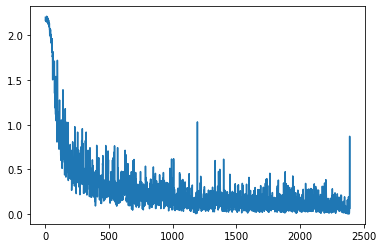

In [8]:
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [9]:
print(t_train.shape)
batch_size = 200
total_correct = 0

running_loss = 0.0
accuracy = 0.0
test_size = 1000
test_data_idx = np.random.choice(x_test.shape[0], test_size)
for i in tqdm(test_data_idx):
    x = x_test[i].reshape(1, 1, 28, 28)
    labels = t_test[i]

    outputs = model.forward(x)
    pred = ops.Softmax(outputs)
    labels = labels.reshape(pred.shape)
    c = (np.argmax(labels, 1) == np.argmax(pred, 1)).squeeze()
    total_correct += np.sum(c)

print(f"Accuracy:{total_correct/test_size}")


(60000, 10)


100%|██████████| 1000/1000 [00:13<00:00, 72.58it/s]

Accuracy:0.959


In [10]:
model.save("220124_2023.pkl")